In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
import help_functions as hf

import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
import alphashape
from matplotlib.lines import Line2D
from shapely.geometry import Polygon

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from gnn_architecture import MyGnn  # or whatever you need to import
import help_functions as hf
import gnn_io as gio
from enum import IntEnum

<!-- ABSTRACT -->

The goal of this script is to check how well the model performs on the test set. For this, we will look at the overall test set, as well as some specific cases, that we will visualize.

In [2]:
# Parameters to adapt

run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_21_10_2024/'
point_net_conv_layer_structure_local_mlp = "64,128"
point_net_conv_layer_structure_global_mlp = "256,64"
gat_conv_layer_structure = "128,256,512,256" 
# for new model, remove last 256
dropout = 0.3
use_dropout = False 
predict_mode_stats = False
in_channels = 13
out_channels = 1 

# The rest we can usually leave as is
pnc_l_string = point_net_conv_layer_structure_local_mlp.replace(',', '_')
pnc_g_string = point_net_conv_layer_structure_global_mlp.replace(',', '_') 
gat_string = gat_conv_layer_structure.replace(',', '_')

unique_model_description = f"pnc_local_[{pnc_l_string}]_" + \
f"pnc_global_[{pnc_g_string}]_" + \
f"gat_conv_[{gat_string}]_" + \
f"use_dropout_{use_dropout}_" + \
f"dropout_{dropout}_" + \
f"predict_mode_stats_{predict_mode_stats}" + "/"
        
run_path = run_path + unique_model_description
base_case_path = '../../data/test_data/pop_1pm_basecase_mean_links_NEW.geojson'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

In [3]:
# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [4]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout, 
                    predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=66, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  ))
  (point_net_conv_3): PointNetConv(local_nn=Sequential(
    (0)

In [5]:
def compute_r2_torch_with_mean_targets(mean_targets, preds, targets):
    ss_tot = torch.sum((targets - mean_targets) ** 2)
    ss_res = torch.sum((targets - preds) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

def validate_model_on_test_set(model, dataset, loss_func, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.inference_mode():
        if isinstance(dataset, list):
            for data in dataset:
                input_node_features, targets = data.x.to(device), data.y.to(device)
                predicted = model(data.to(device))
                loss = loss_func(predicted, targets).item()
                total_loss += loss
                all_preds.append(predicted)
                all_targets.append(targets)
        else:
            input_node_features, targets = dataset.x.to(device), dataset.y.to(device)
            predicted = model(dataset.to(device))
            loss = loss_func(predicted, targets).item()
            total_loss += loss
            all_preds.append(predicted)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    mean_targets = torch.mean(all_targets)
    r_squared = compute_r2_torch_with_mean_targets(mean_targets=mean_targets, preds=all_preds, targets=all_targets)
    baseline_loss = loss_func(all_targets, torch.full_like(all_preds, mean_targets))
    
    avg_loss = total_loss / len(dataset)
    
    return avg_loss, r_squared, all_targets, all_preds, baseline_loss

# Example usage:
loss_fct = torch.nn.MSELoss()
test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

print(f"Test Loss: {test_loss_my_test_data}")
print(f"R-squared: {r_squared_my_test_data}")
print(f"Baseline Loss: {baseline_loss_my_test_data}")

Test Loss: 1.8414423496910264
R-squared: 0.3692609667778015
Baseline Loss: 2.919499158859253


# Next, we will look at single elements of the test set and visualize the performance of the model.


In [6]:
# Pick the first element of the test set
i = 0

my_test_data = test_set_loader.dataset[i]
my_test_x = test_set_loader.dataset[i].x
my_test_x = my_test_x.to('cpu')

test_loss_my_test_data, r_squared_my_test_data, actual_vals_my_test_data, predictions_my_test_data, baseline_loss_my_test_data = validate_model_on_test_set(model, my_test_data, loss_fct, device)

print(f"Test Loss: {test_loss_my_test_data}")
print(f"R-squared: {r_squared_my_test_data}")
print(f"Baseline Loss: {baseline_loss_my_test_data}")

inversed_x = scaler_x.inverse_transform(my_test_x)

Test Loss: 0.26710108915964764
R-squared: 0.40502434968948364
Baseline Loss: 2.6935665607452393


In [28]:
from enum import IntEnum

class EdgeFeatures(IntEnum):
    VOL_BASE_CASE = 0
    CAPACITY_BASE_CASE = 1
    CAPACITIES_NEW = 2
    CAPACITY_REDUCTION = 3
    FREESPEED = 4
    HIGHWAY = 5
    LENGTH = 6
    ALLOWED_MODE_CAR = 7
    ALLOWED_MODE_BUS = 8
    ALLOWED_MODE_PT = 9
    ALLOWED_MODE_TRAIN = 10
    ALLOWED_MODE_RAIL = 11
    ALLOWED_MODE_SUBWAY = 12
    
# Custom mapping for highway types
highway_mapping = {
    'trunk': 0, 'trunk_link': 0, 'motorway_link': 0,
    'primary': 1, 'primary_link': 1,
    'secondary': 2, 'secondary_link': 2,
    'tertiary': 3, 'tertiary_link': 3,
    'residential': 4, 'living_street': 5,
    'pedestrian': 6, 'service': 7,
    'construction': 8, 'unclassified': 9,
    'pt': -1, 
}
    
def data_to_geodataframe_with_og_values(data, original_gdf, predicted_values, inversed_x):
    target_values = data.y.cpu().numpy()
    predicted_values = predicted_values.cpu().numpy() if isinstance(predicted_values, torch.Tensor) else predicted_values
    
    edge_data = {
        'from_node': original_gdf["from_node"].values,
        'to_node': original_gdf["to_node"].values,
        'vol_base_case': inversed_x[:, EdgeFeatures.VOL_BASE_CASE],  
        'capacity_base_case': inversed_x[:, EdgeFeatures.CAPACITY_BASE_CASE],  
        'capacities_new': inversed_x[:, EdgeFeatures.CAPACITIES_NEW],  
        'capacity_reduction': inversed_x[:, EdgeFeatures.CAPACITY_REDUCTION],  
        'freespeed': inversed_x[:, EdgeFeatures.FREESPEED],  
        # 'highway': inversed_x[:, EdgeFeatures.HIGHWAY],
        'highway': original_gdf['highway'].values,
        'length': inversed_x[:, EdgeFeatures.LENGTH],        
        'allowed_mode_car': inversed_x[:, EdgeFeatures.ALLOWED_MODE_CAR],
        'allowed_mode_bus': inversed_x[:, EdgeFeatures.ALLOWED_MODE_BUS],
        'allowed_mode_pt': inversed_x[:, EdgeFeatures.ALLOWED_MODE_PT],
        'allowed_mode_train': inversed_x[:, EdgeFeatures.ALLOWED_MODE_TRAIN],
        'allowed_mode_rail': inversed_x[:, EdgeFeatures.ALLOWED_MODE_RAIL],
        'allowed_mode_subway': inversed_x[:, EdgeFeatures.ALLOWED_MODE_SUBWAY],
        'vol_car_change_actual': target_values.squeeze(),  
        'vol_car_change_predicted': predicted_values.squeeze(),
        
    }
    edge_df = pd.DataFrame(edge_data)
    edge_df['geometry'] = original_gdf["geometry"].values
    gdf = gpd.GeoDataFrame(edge_df, geometry='geometry')
    return gdf

gdf_with_og_values = data_to_geodataframe_with_og_values(data=my_test_data, original_gdf=links_base_case, predicted_values=predictions_my_test_data, inversed_x=inversed_x)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)

In [9]:
# indices_roads_with_highway_primary_sec_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([1,2,3])].index
# indices_roads_with_highway_primary_ = gdf_with_og_values[gdf_with_og_values['highway'].isin([1])].index
# indices_roads_with_highway_sec = gdf_with_og_values[gdf_with_og_values['highway'].isin([2])].index
# indices_roads_with_highway_tertiary = gdf_with_og_values[gdf_with_og_values['highway'].isin([3])].index
# indices_roads_with_highway_not_primary_sec_tertiary = gdf_with_og_values[~gdf_with_og_values['highway'].isin([1, 2, 3])].index

# tolerance = 1e-3
# indices_roads_with_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] < -1e-3].index
# indices_roads_with_no_cap_reduction = gdf_with_og_values[gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3].index

# indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] < -1e-3)
# ].index
# indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction = gdf_with_og_values[
#     (gdf_with_og_values['highway'].isin([1, 2, 3])) & 
#     (gdf_with_og_values['capacity_reduction_rounded'] >= -1e-3)
# ].index

# def validate_model_on_indices(indices, gdf, loss_fct, loss_fct_aux):
#     actual_vals = gdf.loc[indices, 'vol_car_change_actual']
#     predicted_vals = gdf.loc[indices, 'vol_car_change_predicted']
#     actual_vals = actual_vals.to_numpy()
#     predicted_vals = predicted_vals.to_numpy()
#     actual_mean = torch.mean(torch.tensor(actual_vals))
#     mse = loss_fct(torch.tensor(actual_vals), torch.tensor(predicted_vals))
#     baseline = loss_fct(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean))
#     variance = torch.var(loss_fct_aux(torch.tensor(actual_vals), torch.full_like(torch.tensor(actual_vals), actual_mean)))
#     r_squared = hf.compute_r2_torch(preds=torch.tensor(predicted_vals), targets=torch.tensor(actual_vals))
    
#     baseline = round(baseline.item(), 2)
#     mse = round(mse.item(), 2)
#     r_squared = round(r_squared.item(), 2)
#     variance = round(variance.item(), 2)
#     return baseline, mse, r_squared, variance

# loss_fct_aux = torch.nn.MSELoss(reduction='none')

# baseline_primary_sec_tertiary, mse_primary_sec_tertiary, r_squared_primary_sec_tertiary, variance_primary_sec_tertiary = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_primary, mse_primary, r_squared_primary, variance_primary = validate_model_on_indices(indices_roads_with_highway_primary_, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_sec, mse_sec, r_squared_sec, variance_sec = validate_model_on_indices(indices_roads_with_highway_sec, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_tertiary, mse_tertiary, r_squared_tertiary, variance_tertiary = validate_model_on_indices(indices_roads_with_highway_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_not_primary_sec_tertiary, mse_not_primary_sec_tertiary, r_squared_not_primary_sec_tertiary, variance_not_primary_sec_tertiary = validate_model_on_indices(indices_roads_with_highway_not_primary_sec_tertiary, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_cap_reduction, mse_cap_reduction, r_squared_cap_reduction, variance_cap_reduction = validate_model_on_indices(indices_roads_with_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_no_cap_reduction, mse_no_cap_reduction, r_squared_no_cap_reduction, variance_no_cap_reduction = validate_model_on_indices(indices_roads_with_no_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_primary_sec_tertiary_and_cap_reduction, mse_primary_sec_tertiary_and_cap_reduction, r_squared_primary_sec_tertiary_and_cap_reduction, variance_primary_sec_tertiary_and_cap_reduction = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary_and_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)
# baseline_primary_sec_tertiary_and_not_cap_reduction, mse_primary_sec_tertiary_and_not_cap_reduction, r_squared_primary_sec_tertiary_and_not_cap_reduction, variance_primary_sec_tertiary_and_not_cap_reduction = validate_model_on_indices(indices_roads_with_highway_primary_sec_tertiary_and_not_cap_reduction, gdf_with_og_values, loss_fct, loss_fct_aux)

# print("Primary, Secondary, Tertiary Roads - Baseline:", baseline_primary_sec_tertiary, "MSE:", mse_primary_sec_tertiary, "R^2:", r_squared_primary_sec_tertiary, "Variance:", variance_primary_sec_tertiary)
# print("Primary Roads - Baseline:", baseline_primary, "MSE:", mse_primary, "R^2:", r_squared_primary, "Variance:", variance_primary)
# print("Secondary Roads - Baseline:", baseline_sec, "MSE:", mse_sec, "R^2:", r_squared_sec, "Variance:", variance_sec)
# print("Tertiary Roads - Baseline:", baseline_tertiary, "MSE:", mse_tertiary, "R^2:", r_squared_tertiary, "Variance:", variance_tertiary)
# print("Non-Primary, Non-Secondary, Non-Tertiary Roads - Baseline:", baseline_not_primary_sec_tertiary, "MSE:", mse_not_primary_sec_tertiary, "R^2:", r_squared_not_primary_sec_tertiary, "Variance:", variance_not_primary_sec_tertiary)
# print("Capacity Reduction Roads - Baseline:", baseline_cap_reduction, "MSE:", mse_cap_reduction, "R^2:", r_squared_cap_reduction, "Variance:", variance_cap_reduction)
# print("No Capacity Reduction Roads - Baseline:", baseline_no_cap_reduction, "MSE:", mse_no_cap_reduction, "R^2:", r_squared_no_cap_reduction, "Variance:", variance_no_cap_reduction)
# print("Primary, Secondary, Tertiary Roads with Capacity Reduction - Baseline:", baseline_primary_sec_tertiary_and_cap_reduction, "MSE:", mse_primary_sec_tertiary_and_cap_reduction, "R^2:", r_squared_primary_sec_tertiary_and_cap_reduction, "Variance:", variance_primary_sec_tertiary_and_cap_reduction)
# print("Primary, Secondary, Tertiary Roads with No Capacity Reduction - Baseline:", baseline_primary_sec_tertiary_and_not_cap_reduction, "MSE:", mse_primary_sec_tertiary_and_not_cap_reduction, "R^2:", r_squared_primary_sec_tertiary_and_not_cap_reduction, "Variance:", variance_primary_sec_tertiary_and_not_cap_reduction)

# # Convert the GeoDataFrame to the appropriate coordinate reference system (CRS) for length calculation
# gdf_in_meters = gdf_with_og_values.to_crs("EPSG:32633")
# gdf_in_meters['length'] = gdf_in_meters.length
# total_length = gdf_in_meters['length'].sum() / 1000
# print(f"Total length of the street network: {total_length:.2f} km")
# gdf_with_reductions = gdf_in_meters.loc[indices_roads_with_cap_reduction]
# total_length_with_reductions = gdf_with_reductions['length'].sum() / 1000
# print(f"Total length of the street network with capacity reductions: {total_length_with_reductions:.2f} km")
# # Can do this for all indices

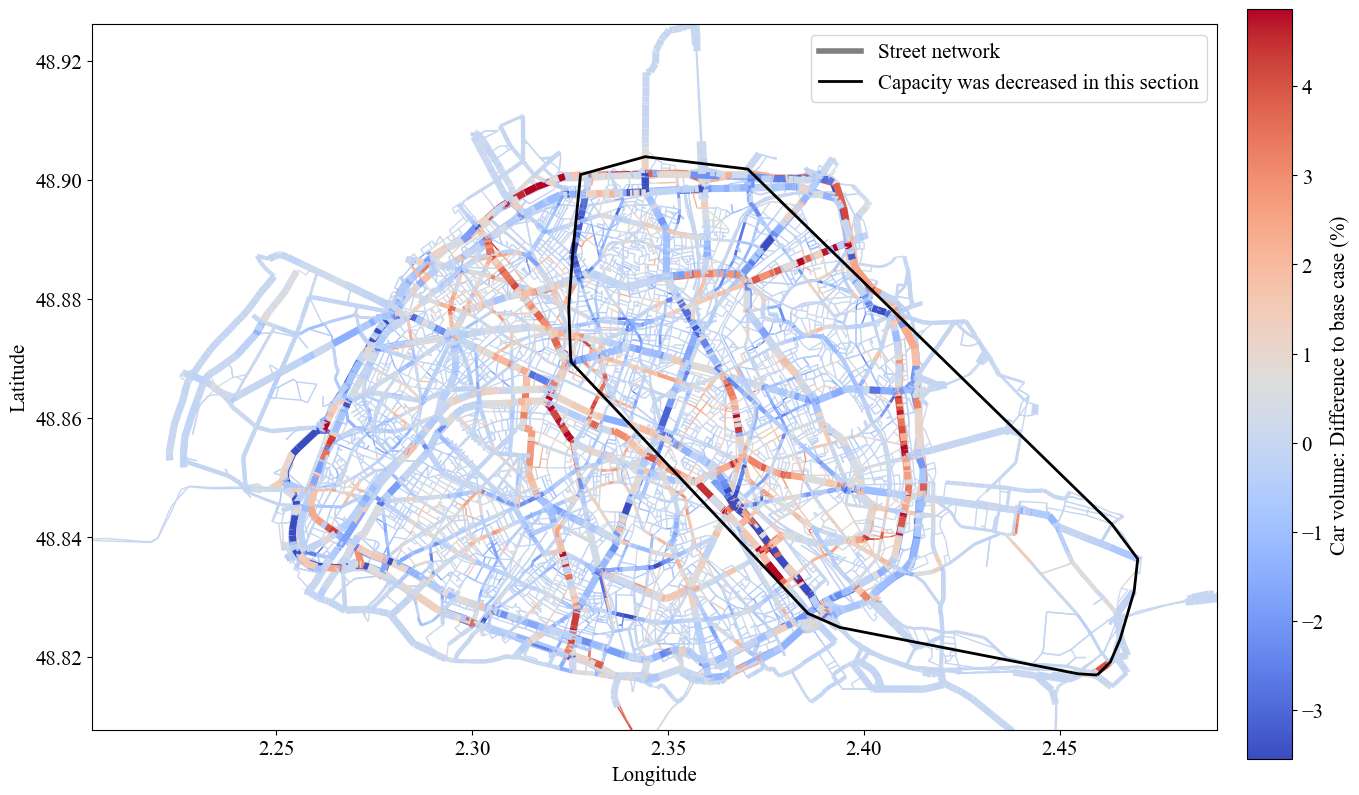

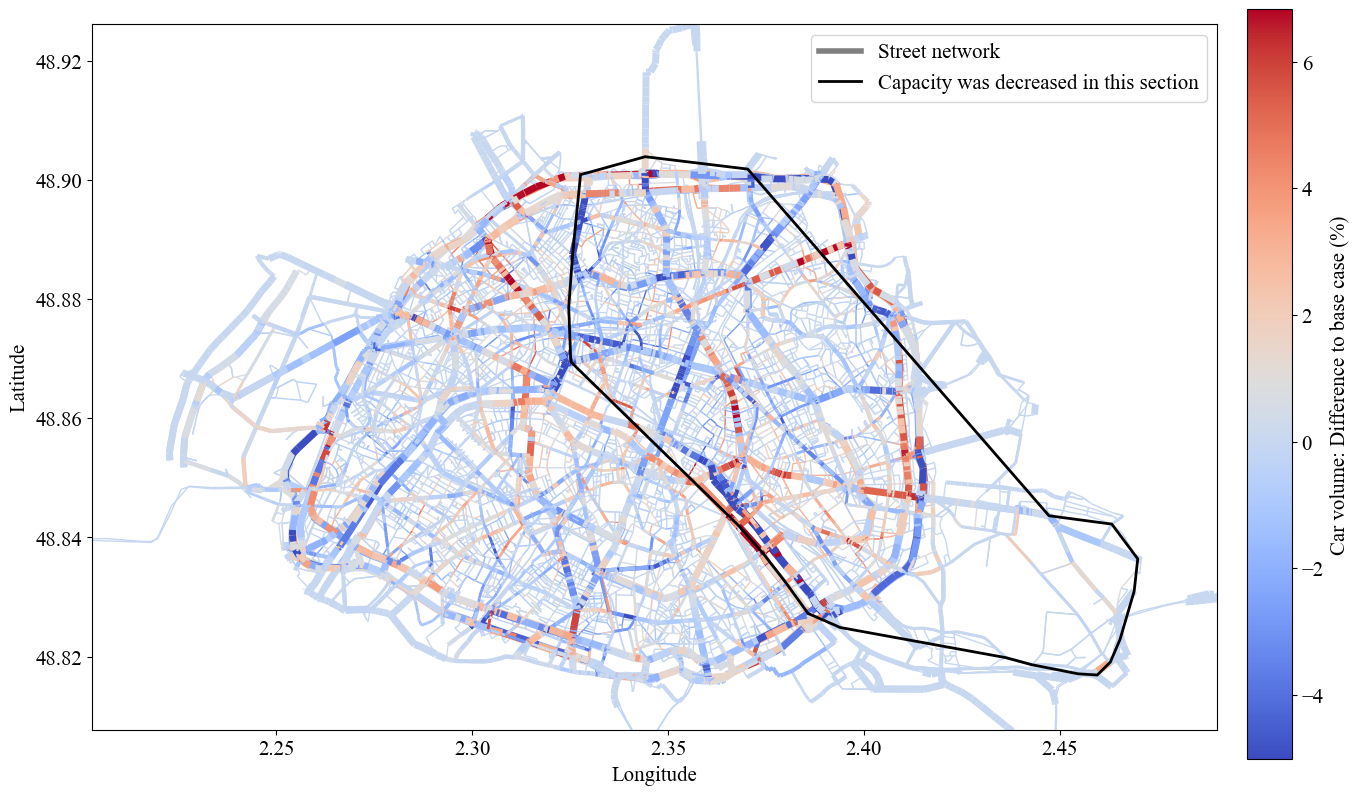

In [34]:
fixed_norm_max = 5
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(highway_mapping)

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                        save_it=False, number_to_plot=0, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=False, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=False, 
                        number_to_plot=None, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=False, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None)